# Scandal Period Classifier 

### Background 

A research agency would like to detect period of time where various agencies of certain government 
received unusuallt high news coverage. These anomalies are used as a proxy for period where this 
agency experienced some sort of scandal. 

### Goal 

Use the provided data to build a classifier that predicts whether an article was
written during a 'scandal period' for the agency PEMEX. Keep in mind that
different scandals might have different determining characteristics.

### Data 

####  anomaly_periods.csv 
- Contains the anomaly periods detected for each agency, including the start and end date. 

      metadata:
          agency: acronym for the government agency
          start_date: identified starting date of the anomaly period
          end_date: identified ending date of the anomaly period
 Both dates are inclusive. 
 
####  article_data.csv 
- Contains newspaper articles from several sources, each of which mentions a government agency. 

      metadata:
          id:       id of the article
          source:   newspaper that wrote the article
          date:     date article was published
          title:    title of the article
          byline:   byline of the article
          story:    article text
          agencies: agency/agencies mentioned in the article
          
- Data can be found at https://drive.google.com/file/d/1uSj2taYF0XgpSt3AHEOvPsrcAsPhzuG5/view?usp=sharing  


## Imports

In [7]:
# General imports
import time
import random 
import stop_words
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from stop_words import get_stop_words
from tqdm import tqdm_notebook
from IPython.display import display

# Transformers
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer 

# Algorithms & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

# Metrics & Model selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, confusion_matrix 

# Texts are in Spanish, so set up Spanish stopwords
spanish_stopwords =  get_stop_words('spanish')
print("Spanish stopwords:") 
print(spanish_stopwords)

Spanish stopwords:
['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fue

We will filter the stopwords above as a part of basic preprocessing/text cleaning later. 

## Data cleaning

### Loading and inspecting the data 

In [8]:
# Load data and parse to csv
path_anomaly = "../data_raw/anomaly_periods.csv"
path_data = "../data_raw/article_data.csv"
anomaly_periods = pd.read_csv(path_anomaly, index_col=0)
article_data = pd.read_csv(path_data, index_col=0)

Let's now inspect the shape of the data and their contents

In [9]:
# Inspect the shape 
print("anomaly_periods data shape: {}".format(anomaly_periods.shape))
print("article_data data shape: {}".format(article_data.shape))

anomaly_periods data shape: (149, 3)
article_data data shape: (77897, 7)


#### Anomaly periods

In [10]:
display(anomaly_periods.head(20))

,agency,start_date,end_date
0,INM,2005-06-28,2005-07-07
1,SEDESOL,2005-07-29,2005-08-12
2,SAGARPA,2005-08-05,2005-08-16
3,SEMARNAT,2005-08-16,2005-08-26
4,SEDENA,2005-09-15,2005-09-21
5,SSP,2005-09-18,2005-09-28
6,SAGARPA,2005-09-21,2005-10-02
7,SENER,2005-09-26,2005-10-03
8,IMSS,2005-09-28,2005-10-21
9,SAGARPA,2005-10-16,2005-10-22


#### Article data

In [11]:
display(article_data.head(10))

,id,source,date,title,byline,story,agencies
0,76056,NaN,2011-01-11,Rinden honores a víctima de explosión en Puebla,NaN,PUEBLA .- Elementos de la Policía Municipal de...,['PEMEX']
1,71954,Reforma (Mexico),2009-10-05,Alistan concesión del Chiapas Mayab; Informa S...,BYLINE: Lilián Cruz,El ferrocarril Chiapas Mayab podría tener nuev...,['PEMEX']
2,176322,El Universal (Mexico),2007-12-14,Guerrilla: el tercer desaparecido,BYLINE: ALEJANDRO JIMÉNEZ,"Se le ha puesto menos atención a su caso, pero...",['PGR']
3,189079,Reforma (Mexico),2011-06-17,PLAZA PÚBLICA / Gordillo va por el ISSSTE,BYLINE: Miguel Ángel Granados Chapa,El Instituto de Seguridad y Servicios Sociales...,['PGR' 'SFP']
4,194217,El Universal (Mexico),2012-04-01,Rezan en la basílica por De la Madrid y Jorge ...,NaN,"MÉXICO .- El cardenal Norberto Rivera Carrera,...",['PGR' 'SEGOB']
5,126536,El Universal (Mexico),2008-08-18,Vendedores de droga burlan a los policías,BYLINE: Luis Guillermo Hernández,"La primera vez que la presentaron, Rosario La ...",['PGR' 'SSP']
6,76329,Reforma (Mexico),2011-07-01,Un Vistazo,"BYLINE: Monserrat Bosque, Nallely Ortigoza, Al...",Acusan productores de maíz falta de apoyo por ...,['PEMEX']
7,9599,Reforma (Mexico),2015-12-20,Fuerza académica; Universitarios. ITAM. LOS ME...,BYLINE: Daniela Flores Gómez,Orden y disciplina es lo que distingue a esto...,['CFE' 'PEMEX']
8,87906,Reforma (Mexico),2015-12-07,Cartas a Reforma,"BYLINE: Clara Vargas, Francisco Dueñas, Caroli...","Los 'no' faltantes No a la corrupción, no a ...",['PEMEX']
9,71858,Reforma (Mexico),2009-08-22,Crece 80% el gasto público,BYLINE: Arturo Rivero,No hay reforma fiscal que soporte el crecimien...,['PEMEX']


### Cleaning the data

We will need to to some preprocessing on this data if we want to feed it to a classification algorithm. We will do the following: 
    - Anomaly periods dataframe 
        1. Subset periods that correspont to the PEMEX agency 
        2. Convert from string to datatime datatype 
        3. Drop agency column (redundant in this case) 
        4. Obtain a dictionary of the respective dates (will not use here, but could be used for 
        a multi-label classification problem)
    - Articles data  
        1. Subset articles that mention the PEMEX agency 
        2. Convert dates to datetime 
        3. Replace np.nan entries with "NONE", then with some default, out-og-range date. 

In [12]:
# Clean up anomaly periods df
PEMEX_anomaly_p = anomaly_periods[anomaly_periods['agency'].str.match('PEMEX')] # subset for PEMEX periods
PEMEX_anomaly_p[["start_date","end_date"]].apply(pd.to_datetime)    # convert to datatime
PEMEX_anomaly_p = PEMEX_anomaly_p.drop('agency', axis=1) # they all are the same agency, redundant
PEM_anomp_dict = PEMEX_anomaly_p.to_dict('index') # fetch dictionary 

In [13]:
display(PEMEX_anomaly_p.head(10))

,start_date,end_date
30,2007-07-05,2007-07-18
33,2007-09-08,2007-09-16
45,2008-03-24,2008-04-18
53,2008-07-13,2008-07-30
111,2013-01-27,2013-02-11
117,2013-08-10,2013-08-21
125,2014-07-23,2014-08-05


In [14]:
PEM_anomp_dict

{30: {'start_date': '2007-07-05', 'end_date': '2007-07-18'},
 33: {'start_date': '2007-09-08', 'end_date': '2007-09-16'},
 45: {'start_date': '2008-03-24', 'end_date': '2008-04-18'},
 53: {'start_date': '2008-07-13', 'end_date': '2008-07-30'},
 111: {'start_date': '2013-01-27', 'end_date': '2013-02-11'},
 117: {'start_date': '2013-08-10', 'end_date': '2013-08-21'},
 125: {'start_date': '2014-07-23', 'end_date': '2014-08-05'}}

In [15]:
# Clean up artcles data 
PEMEX_article_data = article_data[article_data['agencies'].str.contains("PEMEX")] # subset PEMEX articles
PEMEX_article_data["date"].apply(pd.to_datetime) # convert dates to datetime format 
PEMEX_article_data = PEMEX_article_data.replace(np.nan, "NONE") # replace nan by "NONE"
PEMEX_article_data["date"] = PEMEX_article_data["date"].replace("NONE", pd.to_datetime('1-1-1')) # replace by default dates

In [16]:
display(PEMEX_article_data.head(10))

,id,source,date,title,byline,story,agencies
0,76056,NONE,2011-01-11,Rinden honores a víctima de explosión en Puebla,NONE,PUEBLA .- Elementos de la Policía Municipal de...,['PEMEX']
1,71954,Reforma (Mexico),2009-10-05,Alistan concesión del Chiapas Mayab; Informa S...,BYLINE: Lilián Cruz,El ferrocarril Chiapas Mayab podría tener nuev...,['PEMEX']
6,76329,Reforma (Mexico),2011-07-01,Un Vistazo,"BYLINE: Monserrat Bosque, Nallely Ortigoza, Al...",Acusan productores de maíz falta de apoyo por ...,['PEMEX']
7,9599,Reforma (Mexico),2015-12-20,Fuerza académica; Universitarios. ITAM. LOS ME...,BYLINE: Daniela Flores Gómez,Orden y disciplina es lo que distingue a esto...,['CFE' 'PEMEX']
8,87906,Reforma (Mexico),2015-12-07,Cartas a Reforma,"BYLINE: Clara Vargas, Francisco Dueñas, Caroli...","Los 'no' faltantes No a la corrupción, no a ...",['PEMEX']
9,71858,Reforma (Mexico),2009-08-22,Crece 80% el gasto público,BYLINE: Arturo Rivero,No hay reforma fiscal que soporte el crecimien...,['PEMEX']
10,76027,El Universal (Mexico),2011-03-01,Reservas internacionales del Banco de México b...,BYLINE: El Universal (Mexico),Las reservas internacionales del Banco de Méxi...,['PEMEX']
12,63416,Reforma (Mexico),2007-10-30,Exigen a Pemex controlar derrame; Indaga PGR m...,BYLINE: Claudia Guerrero y Benito Jiménez,La Comisión de Medio Ambiente del Senado de la...,['PEMEX' 'PGR' 'SEMARNAT']
13,63416,Reforma (Mexico),2007-10-30,Exigen a Pemex controlar derrame; Indaga PGR m...,BYLINE: Claudia Guerrero y Benito Jiménez,La Comisión de Medio Ambiente del Senado de la...,['PEMEX' 'PGR' 'SEMARNAT']
14,6955,Reforma (Mexico),2013-10-17,Alerta Narro por riesgos de soberanía energética,BYLINE: Claudia Guerrero,"José Narro Robles, Rector de la Universidad Na...",['CFE' 'PEMEX' 'SENER']


Next, we would like to determine whether these articles are within a scadal period or not. For this, we implement a helper function. 

In [17]:
def is_within_scandal(date):
    """ Date is in datetime format. 
        Returns a touple with whether or not it belongs an anomaly, 
        and the anomaly period index where it was found. 
        Index will be -1 if wasn't found. """
    is_within = False
    anomp_index = -1 # anomaly period key where it was found
    date = pd.to_datetime(date) # convert to datatime
    for i in PEM_anomp_dict: # get the key, convert to time format
        lower = pd.to_datetime(PEM_anomp_dict[i]['start_date']) # lower bound date 
        upper = pd.to_datetime(PEM_anomp_dict[i]['end_date']) # upper bound date 
        if( date >= lower and date <= upper):
            is_within = True
            anomp_index = i
            break
    return is_within, anomp_index

In [18]:
def label_data(): 
    """
    Determines whether article belongs to a scandal period, 
    and assigns labels correspondingly. 
    @returns: 
        @anomaly_index: list containing the index of an article if it is an scandal, 
                        and -1 otherwise. 
        @within_scandal: list containing for each article 1 is it is in scandal period, 
                        and 0 otherwise. 
    """
    anomaly_index = [] # will store the index where scandal was found
    within_scandal = [] # 1 if included, 0 if not 

    # Iterate throught the artciles obtaining the dates 
    for row in tqdm_notebook(PEMEX_article_data.itertuples(),desc="iterating through tuples..."):
        date = str(row.date) # fetch date as str
        is_within, anomp_index = is_within_scandal(date) # apply previous function

        # show some examples 
        if anomp_index % 33 == 0: 
            print("index: {}  date: {}  source: {} agency: {}".format(row.Index,date, str(row.source), str(row.agencies)))

        # determine if it's within 
        if(is_within):
            anomaly_index.append(anomp_index) # fetch index if in scandal
            within_scandal.append(1) # True
        else: 
            anomaly_index.append(-1) # append -1 if not a scandal 
            within_scandal.append(0) # False

    return anomaly_index, within_scandal 

# call the function 
anomaly_index, within_scandal = label_data()

index: 1184  date: 2007-09-12  source: Reforma (Mexico) agency: ['PEMEX']
index: 2194  date: 2007-09-12  source: Reforma (Mexico) agency: ['PEMEX']
index: 4098  date: 2007-09-13  source: Reforma (Mexico) agency: ['PEMEX' 'SEECO']
index: 6748  date: 2007-09-12  source: Reforma (Mexico) agency: ['CFE' 'PEMEX' 'SFP']
index: 7203  date: 2007-09-12  source: Reforma (Mexico) agency: ['PEMEX']
index: 7229  date: 2007-09-14  source: Reforma (Mexico) agency: ['PEMEX' 'PGR' 'SEDENA' 'SEGOB']
index: 7230  date: 2007-09-14  source: Reforma (Mexico) agency: ['PEMEX' 'PGR' 'SEDENA' 'SEGOB']
index: 7716  date: 2007-09-13  source: Reforma (Mexico) agency: ['PEMEX']
index: 8430  date: 2007-09-11  source: Reforma (Mexico) agency: ['PEMEX']
index: 8867  date: 2007-09-15  source: Reforma (Mexico) agency: ['PEMEX']
index: 9067  date: 2007-09-10  source: Reforma (Mexico) agency: ['PEMEX']
index: 10557  date: 2007-09-09  source: Reforma (Mexico) agency: ['IMSS' 'PEMEX' 'SEDENA']
index: 11282  date: 2007-09-0

Next, we assign these as new columns of the dataframe. 

In [19]:
PEMEX_article_data['within_scandal'] = within_scandal
PEMEX_article_data['anomaly_index'] = anomaly_index 

In [20]:
display(PEMEX_article_data.head(10))

,id,source,date,title,byline,story,agencies,within_scandal,anomaly_index
0,76056,NONE,2011-01-11,Rinden honores a víctima de explosión en Puebla,NONE,PUEBLA .- Elementos de la Policía Municipal de...,['PEMEX'],0,-1
1,71954,Reforma (Mexico),2009-10-05,Alistan concesión del Chiapas Mayab; Informa S...,BYLINE: Lilián Cruz,El ferrocarril Chiapas Mayab podría tener nuev...,['PEMEX'],0,-1
6,76329,Reforma (Mexico),2011-07-01,Un Vistazo,"BYLINE: Monserrat Bosque, Nallely Ortigoza, Al...",Acusan productores de maíz falta de apoyo por ...,['PEMEX'],0,-1
7,9599,Reforma (Mexico),2015-12-20,Fuerza académica; Universitarios. ITAM. LOS ME...,BYLINE: Daniela Flores Gómez,Orden y disciplina es lo que distingue a esto...,['CFE' 'PEMEX'],0,-1
8,87906,Reforma (Mexico),2015-12-07,Cartas a Reforma,"BYLINE: Clara Vargas, Francisco Dueñas, Caroli...","Los 'no' faltantes No a la corrupción, no a ...",['PEMEX'],0,-1
9,71858,Reforma (Mexico),2009-08-22,Crece 80% el gasto público,BYLINE: Arturo Rivero,No hay reforma fiscal que soporte el crecimien...,['PEMEX'],0,-1
10,76027,El Universal (Mexico),2011-03-01,Reservas internacionales del Banco de México b...,BYLINE: El Universal (Mexico),Las reservas internacionales del Banco de Méxi...,['PEMEX'],0,-1
12,63416,Reforma (Mexico),2007-10-30,Exigen a Pemex controlar derrame; Indaga PGR m...,BYLINE: Claudia Guerrero y Benito Jiménez,La Comisión de Medio Ambiente del Senado de la...,['PEMEX' 'PGR' 'SEMARNAT'],0,-1
13,63416,Reforma (Mexico),2007-10-30,Exigen a Pemex controlar derrame; Indaga PGR m...,BYLINE: Claudia Guerrero y Benito Jiménez,La Comisión de Medio Ambiente del Senado de la...,['PEMEX' 'PGR' 'SEMARNAT'],0,-1
14,6955,Reforma (Mexico),2013-10-17,Alerta Narro por riesgos de soberanía energética,BYLINE: Claudia Guerrero,"José Narro Robles, Rector de la Universidad Na...",['CFE' 'PEMEX' 'SENER'],0,-1


### Labels distribution 

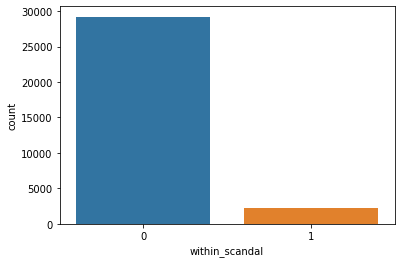

In [21]:
plt.figure(1)
sns.countplot(PEMEX_article_data['within_scandal'] ,label="Count")
plt.show() 

Note that this distribution is **extremely unbalanced**. In fact, we will use classification algorithms in here, but in fact, not that it would make more sense to use an **anomaly detection algorithm** (such a Gaussian Mixture model, or even a K-neighbour classifier. 

## Fitting classification models

We will now split our data into appropriate test/train sets. We will use the features "title", "byline" and "story" as predictors of the scandal periods, separatedly, and see which one performs best. We also store some statistics on the classifiers to assess their performance. For simplicity, we will only test three models: **Logistic Regression, Multinomial Naive Bayes** and **Linear Support Vector Machines**. 

In [22]:
# Fetch relevant data
X = PEMEX_article_data[['title','byline', 'story']] # features
Y = PEMEX_article_data['within_scandal'] # Labels =  {0,1}
labels = ["Normal Period","Scandal Period"] # label names

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                     train_size=0.9, 
                                                     test_size=0.1, 
                                                     shuffle=True, 
                                                     random_state=42)



# Store statistics
clf_accuracies = {}
clf_cv_accuracies = {} # to store accuracies for each model 
best_estimators = {} # to store best parameter configurations 
running_times ={} # to save running times of fitting the models  

# Verify correct shapes 
print("X.shape = ", X.shape) 
print("Y.shape = ", Y.shape)
print("X_train.shape = ", X_train.shape) 
print("Y_train.shape = ", Y_train.shape)
print("X_test.shape = ", X_test.shape) 
print("Y_test.shape = ", Y_test.shape)

X.shape =  (31483, 3)
Y.shape =  (31483,)
X_train.shape =  (28334, 3)
Y_train.shape =  (28334,)
X_test.shape =  (3149, 3)
Y_test.shape =  (3149,)


In [26]:
# save data locally 
X_train.to_csv("../data_clean/X_train.csv")
X_test.to_csv("../data_clean/X_test.csv") 
Y_train.to_csv("../data_clean/Y_train.csv")
Y_test.to_csv("../data_clean/Y_test.csv") 

C:\Users\jairp\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\Users\jairp\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


## General Pipeline

In all models, we will use the following pipeline: 

`vectorizer` -> `tfidf-transformer` -> `normalizer` -> `classifier` 

Where: 
 - **Vectorizer** : transforms the input text into one hot-encoded vectors 
 - **Transformer** : assigns a tfidf based weight to the vectors 
 - **Normalizer** : normalizes the vectors so they have the same range 
 - **Classifier** : the classifier algorithm

## Logistic Regression ( on 'title')

In [28]:
logreg_pipe = Pipeline([('vect', CountVectorizer(min_df=0, 
                                                 max_df=0.95, 
                                                 ngram_range=(1,1), 
                                                 max_features = 5000,
                                                 stop_words = spanish_stopwords
                                                 )), # max size of vectors
                 ('tfidf', TfidfTransformer(norm='l2', # normalize
                                            use_idf = True, 
                                            smooth_idf=False, 
                                            sublinear_tf=True)), # smoothing 
                 ('clf', LogisticRegression(C=2.5, # inverse regularization strenght 
                                            class_weight=None, 
                                            max_iter=400, 
                                            multi_class='auto', 
                                            penalty='l2', 
                                            solver='saga') )
                 ])
                 

# Fit and train the model 
t0 = time.time()                 
logreg_pipe.fit(X_train['title'], Y_train)
t1 = time.time() 
running_times['Logistic Regression_title'] = t1 - t0 

# Get the 5-folds cross_validation_score with the training data 
logreg_cv_scores = cross_val_score(logreg_pipe, X_train['title'], Y_train, cv=10) # takes some time
logreg_cv_score = round(logreg_cv_scores.mean()*100, 4)
clf_cv_accuracies['Logistic Regression_title'] =logreg_cv_score
print("Logistic Regression cv-accuracy {}%".format(logreg_cv_score))

# Obtain predictions for later
y_pred = logreg_pipe.predict(X_test) # get predictions 

Logistic Regression cv-accuracy 92.8072%


We obtain **92.8 % cross-validation accuracy** on the training data using these parameters of logistic regression. The model above has been adjusted based on the outputs below: that is, we tune the model using grid search as shown below. 

In [30]:
# Set up a random seed 
seed = 42 

# Set up the parameters to search 
params = {"vect__ngram_range" :[(1,1),(1,2),(1,3)], 
          "vect__max_df" : [0.94, 0.95, 0.96], 
          "vect__min_df" : [0.0005, 0.001, 0.005], 
          "vect__max_features" :[4000, 5000, 7000], 
          "tfidf__norm" : ['l1','l2'], 
          "tfidf__use_idf" :[True, False],
          "tfidf__smooth_idf":[True, False], 
          "tfidf__sublinear_tf":[True, False], 
          "clf__penalty": ['l2'], 
          "clf__C": [1.0, 2.0, 2.5], # inverse regularization parameter
          "clf__max_iter": [200,300, 400], 
          "clf__fit_intercept":[True, False], 
          "clf__class_weight":["balanced",None], 
          "clf__solver":['newton-cg', 'lbfgs','saga'], 
          "clf__multi_class":['ovr','multinomial','auto']
          }

# Create a randomized search cross-validation with 5 folds 
# and 10 repetitions. 
random_search_logreg = RandomizedSearchCV(logreg_pipe, 
                                        param_distributions = params, 
                                        cv = 5, # 5  Cross folds
                                        verbose=10,  
                                        random_state = seed, 
                                        n_iter = 10, # number of repetitions
                                        n_jobs = -1 # run in parallel using all processors
                                        )

# Fit again to the random search 
random_search_logreg.fit(X_train['title'], Y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   28.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   29.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.6s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.95,
                                                              max_features=5000,
                                                              min_df=0,
                                         

Let's now inspect the best model

In [32]:
# Obtain report 
best_estimator = random_search_logreg.best_estimator_
y_pred = logreg_pipe.predict(X_test['title']) 
CV_report = classification_report(Y_test, y_pred, 
                                 target_names=labels) 

print("CV report: \n", CV_report)
print("Best estimator: \n", best_estimator)
best_estimators['LogisticRegression_title'] = best_estimator # save this estimator 

CV report: 
                 precision    recall  f1-score   support

 Normal Period       0.93      1.00      0.96      2916
Scandal Period       0.43      0.04      0.07       233

      accuracy                           0.93      3149
     macro avg       0.68      0.52      0.52      3149
  weighted avg       0.89      0.93      0.90      3149

Best estimator: 
 Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=7000, min_df=0.005,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=['a', 'al', 'algo', 'algunas',
                                             'algunos', 'ante', 'antes', 'como',
          

We have a quite bad recall for the Scandal period; this is to be expeceted as the data is extremely unbalanced! 

### Confussion matrix

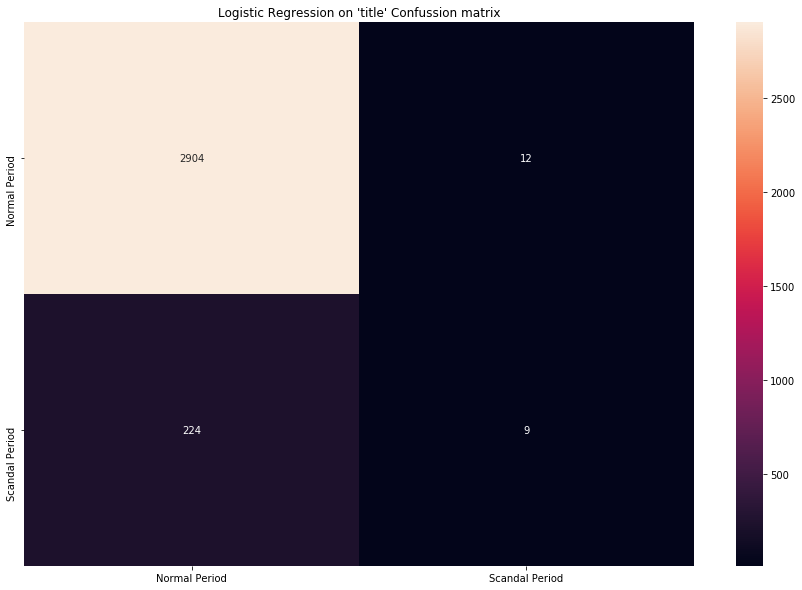

In [34]:
# Display confusion matrix 
confusion_mat = confusion_matrix(Y_test, y_pred).tolist() 
df_cm = pd.DataFrame(confusion_mat, index=labels, 
                     columns=labels) 
plt.figure(2, figsize= (15,10)) 
sns.heatmap(df_cm, annot=True, fmt='g') 
plt.title("Logistic Regression on 'title' Confussion matrix")
plt.savefig('../img/Logistic_Regression_byline_Confussion_matrix.png')    

## Logistic Regression ( on ''byline")

In [49]:
logreg_pipe = Pipeline([('vect', CountVectorizer(min_df=0.001, 
                                                 max_df=0.95, 
                                                 ngram_range=(1,3), 
                                                 max_features = 12000,
                                                 stop_words = spanish_stopwords
                                                 )), # max size of vectors
                 ('tfidf', TfidfTransformer(norm='l1', # normalize
                                            use_idf = False,  
                                            smooth_idf=True, 
                                            sublinear_tf=True)), # smoothing 
                 ('clf', LogisticRegression(C=1.2, # inverse regularization strenght 
                                            class_weight=None, 
                                            max_iter=300, 
                                            multi_class='multinomial', 
                                            penalty='l2', 
                                            solver='saga') )
                 ])
                 

# Fit and train the model 
t0 = time.time()                 
logreg_pipe.fit(X_train['byline'], Y_train)
t1 = time.time() 
running_times['Logistic Regression_byline'] = t1 - t0 

# Get the 5-folds cross_validation_score with the training data 
logreg_cv_scores = cross_val_score(logreg_pipe, X_train['byline'], Y_train, cv=10) # takes some time
logreg_cv_score = round(logreg_cv_scores.mean()*100, 4)
clf_cv_accuracies['Logistic Regression_byline'] =logreg_cv_score
print("Logistic Regression cv-accuracy {}%".format(logreg_cv_score))

# Obtain predictions for later
y_pred = logreg_pipe.predict(X_test) # get predictions 

Logistic Regression cv-accuracy 92.7331%


We obtain **92.74% cross-validation accuracy**. 

In [50]:
# Set up a random seed 
seed = 42 

# Set up the parameters to search 
params = {"vect__ngram_range" :[(1,1),(1,2),(1,3)], 
          "vect__max_df" : [0.94, 0.95, 0.96], 
          "vect__min_df" : [0.01,0.05, 0.1],
          "vect__max_features" : [7000, 10000,12000], 
          "tfidf__norm" : ['l1','l2'], 
          "tfidf__use_idf" :[True, False],
          "tfidf__smooth_idf":[True, False], 
          "tfidf__sublinear_tf":[True, False], 
          "clf__penalty": ['l2'], 
          "clf__C": [0.5,0.8,1.0], # inverse regularization parameter
          "clf__max_iter": [200,300, 400], 
          "clf__fit_intercept":[True, False], 
          "clf__class_weight":["balanced",None], 
          "clf__solver":['newton-cg', 'lbfgs','saga'], 
          "clf__multi_class":['ovr','multinomial','auto']
          }

# Create a randomized search cross-validation with 5 folds 
# and 10 repetitions. 
random_search_logreg = RandomizedSearchCV(logreg_pipe, 
                                        param_distributions = params, 
                                        cv = 5, # 5  Cross folds
                                        verbose=10,  
                                        random_state = seed, 
                                        n_iter = 10, # number of repetitions
                                        n_jobs = -1 # run in parallel using all processors
                                        )

# Fit again to the random search 
random_search_logreg.fit(X_train['byline'], Y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   15.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.95,
                                                              max_features=12000,
                                                              min_df=0.001,
                                    

In [51]:
# Obtain report 
best_estimator = random_search_logreg.best_estimator_
y_pred = logreg_pipe.predict(X_test['byline']) 
CV_report = classification_report(Y_test, y_pred, 
                                 target_names=labels) 

print("CV report: \n", CV_report)
print("Best estimator: \n", best_estimator)
best_estimators['LogisticRegression_byline'] = best_estimator # save this estimator 

C:\Users\jairp\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV report: 
                 precision    recall  f1-score   support

 Normal Period       0.93      1.00      0.96      2916
Scandal Period       0.00      0.00      0.00       233

      accuracy                           0.93      3149
     macro avg       0.46      0.50      0.48      3149
  weighted avg       0.86      0.93      0.89      3149

Best estimator: 
 Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=12000, min_df=0.1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=['a', 'al', 'algo', 'algunas',
                                             'algunos', 'ante', 'antes', 'como',
           

It would seem that with both `byline` and `title` have very similar performance. Therefore we will not bother training on the full stories (as these are lengthy and take quite some time to train on). 

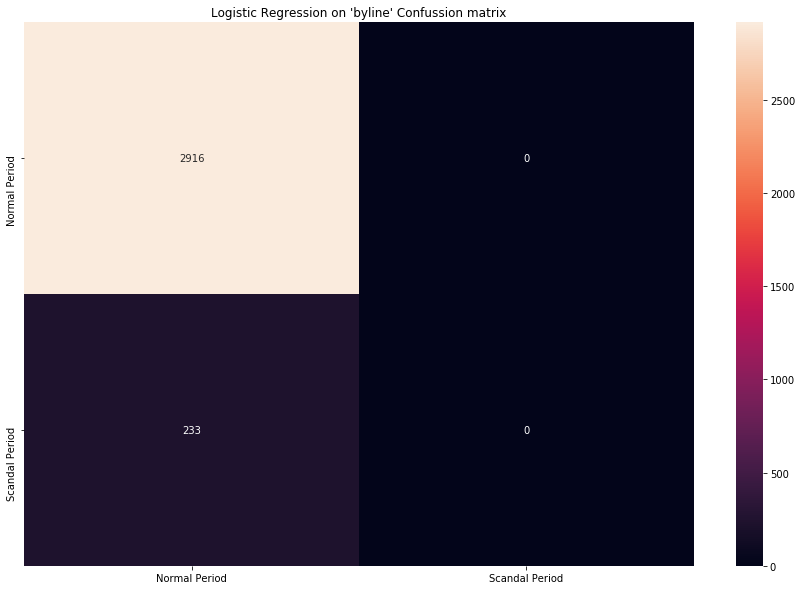

In [52]:
# Display confusion matrix 
y_pred = logreg_pipe.predict(X_test['byline']) 
confusion_mat = confusion_matrix(Y_test, y_pred).tolist() 
df_cm = pd.DataFrame(confusion_mat, index=labels, 
                     columns=labels) 
plt.figure(2, figsize= (15,10)) 
sns.heatmap(df_cm, annot=True, fmt='g') 
plt.title("Logistic Regression on 'byline' Confussion matrix")
plt.savefig('../img/Logistic_Regression_byline_Confussion_matrix.png')  

That's pretty bad, it this classifier is just predicting everything to be a "Normal Period". Recall the problem at the beginning, the right approach would have been to fit an anomaly detection algorithm! 

## Multinomial Bayes ( on 'title') 

In [77]:
# Create Pipeline only with the tfidf vectorizer and the classifier
MN_pipe = Pipeline([ ('vect', TfidfVectorizer(encoding='utf-8',
                                                      strip_accents='unicode', 
                                                      lowercase=True, 
                                                      stop_words='english', 
                                                      ngram_range=(1,1), 
                                                      max_df= 1, 
                                                      min_df = 0, # 0
                                                      max_features=70000,
                                                      norm='l2', 
                                                      smooth_idf=True, 
                                                      sublinear_tf=True,
                                                      use_idf=True)), 
                              ('clf', MultinomialNB(alpha=0.3, # 0.3
                                     fit_prior=False)),   # True
                             ])

# time the code
t0 = time.time()            
MN_pipe.fit(X_train['title'], Y_train) # fit and train the model 
t1 = time.time() 
running_times['Multinomial NB'] = t1 - t0 

# Get the 5-folds cross_validation_score with the real training data
MN_cv_scores = cross_val_score(MN_pipe, X_train['title'], Y_train, cv=5)
MN_cv_score = round(MN_cv_scores.mean()*100, 4)
clf_cv_accuracies['Multinomal_NB_title'] = MN_cv_score
print("Multinomial NB cv-accuracy {}%".format(MN_cv_score))

# obtain and save predictions 
y_pred = MN_pipe.predict(X_test) # get predictions 

Multinomial NB cv-accuracy 90.0473%


In [73]:
params = {"vect__encoding":['utf-8'],
          "vect__strip_accents":['ascii', 'unicode'], 
          "vect__lowercase":[True, False], 
          "vect__stop_words":['english'], 
          "vect__max_df" : [0.7, 0.8, 1.0], 
          "vect__min_df" : [0.0, 0.1, 0.001], 
          "vect__max_features" :[50000, 60000, 70000], 
          "vect__sublinear_tf":[True, False], 
          "vect__use_idf": [True, False], 
          "clf__alpha": [0.28,0.3,0.32], 
          "clf__fit_prior" : [True, False] 
          }

# Set up a random seed  
seed = 42 

# Create a randoized search cross-validation with 5 folds 
# and 10 repetitions. 
random_search_MN = RandomizedSearchCV(MN_pipe, 
                                        param_distributions = params, 
                                        cv = 5, # 5  Cross folds
                                        verbose=10,  
                                        random_state = seed, 
                                        n_iter=10, 
                                        n_jobs = -1 # run in parallel using all processors 
                                        )

# fit splitted data
random_search_MN.fit(X_train['title'], Y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   15.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   16.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.99,
                                                              max_features=70000,
                                                              min_df=0,
                                      

In [78]:
# Obtain report 
best_estimator = random_search_MN.best_estimator_
y_pred = list(random_search_MN.predict(X_test['title']) )
CV_report = classification_report(Y_test, y_pred, 
                                 target_names=labels) 

# Obtain accuracies
MN_acc = round(accuracy_score(y_pred, Y_test)*100, 4)
print("Multinomial Naive Bayes accuracy {}%".format(MN_acc))
clf_accuracies['Multinomial NB'] = MN_acc

# Display reports 
print("CV report: \n", CV_report)
print("Best estimator: \n", best_estimator)
best_estimators['raw MultinomialNB'] = best_estimator

Multinomial Naive Bayes accuracy 92.6326%
CV report: 
                 precision    recall  f1-score   support

 Normal Period       0.93      1.00      0.96      2916
Scandal Period       0.57      0.02      0.03       233

      accuracy                           0.93      3149
     macro avg       0.75      0.51      0.50      3149
  weighted avg       0.90      0.93      0.89      3149

Best estimator: 
 Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=0.7,
                                 max_features=70000, min_df=0.0,
                                 ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                             

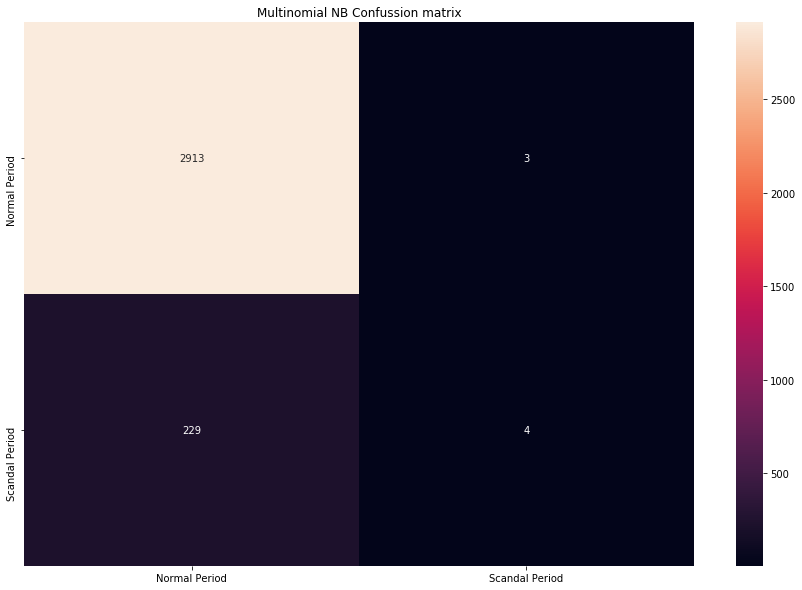

In [81]:
# Display confusion matrix 
confusion_mat = confusion_matrix(Y_test, y_pred).tolist() 
df_cm = pd.DataFrame(confusion_mat, index=labels, 
                     columns=labels) 
plt.figure(2, figsize= (15,10)) 
sns.heatmap(df_cm, annot=True, fmt='g') 
plt.title("Multinomial NB Confussion matrix")
plt.savefig('../img/Multinomial_NB_Confussion_matrix_title.png')  